
# MBTA Bus Delay Gradient Descent Notebook

This notebook mirrors the exploratory workflow from logistic_regression_analysis.ipynb but swaps in a scratch-built gradient-descent solver for the classification step. Run it end-to-end to observe how the iterative optimizer behaves relative to the LBFGS baseline while keeping data prep, sampling, and diagnostics identical.



## Notebook Roadmap

- Configure paths, sampling knobs, and shared column definitions.
- Load us_weather_clean.csv (optionally via a cached Parquet sample) with chunked reads so the workflow can run on laptops.
- Engineer calendar/weather features plus route-hour aggregates, then align the label definition (delay >= 5 minutes) and chronological train/test split with the random-forest experiment.
- Explore the dataset with delay distributions, hourly heatmaps, and weather-response plots.
- Train and evaluate a gradient-descent logistic regression pipeline with standardized preprocessing and class balancing.
- Produce extensive diagnostics: ROC, PR, calibration, confusion matrix, feature coefficients, and slice metrics by hour/weather buckets.



## Setup

Before running, ensure us_weather_clean.csv exists at the repository root (or update CONFIG["csv_path"]). The notebook stores intermediate artifacts under outputs/gradient_descent_notebook/.


In [1]:

import json
import math
import os
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.calibration import calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    accuracy_score,
    average_precision_score,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.validation import check_array, check_is_fitted

try:
    import holidays
except ImportError:
    holidays = None

sns.set_theme(style="whitegrid")
plt.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:

ARTIFACT_DIR = Path("outputs/gradient_descent_notebook")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR = ARTIFACT_DIR / "figures"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

CONFIG = {
    "csv_path": Path("bus_weather_clean.csv"),
    "cache_path": ARTIFACT_DIR / "bus_weather_sample.parquet",
    "use_cache": True,
    "rebuild_cache": False,
    "max_rows": 1_000_000,
    "sample_frac": 0.5,
    "chunksize": 250_000,
    "delay_threshold_min": 5.0,
    "split_date": pd.Timestamp("2024-01-01"),
    "random_state": 42,
    "eda_sample_size": 200_000,
    "csv_search_paths": [
        Path("data"),
        Path("../data"),
        Path("cs506-final-project-team"),
        Path("cs506-final-project-team/data"),
        Path("../cs506-final-project-team"),
        Path("../cs506-final-project-team/data"),
    ],
    "auto_search_csv": True,
    "auto_create_demo_data": True,
    "demo_rows": 50000,
    "demo_csv_path": ARTIFACT_DIR / "demo_bus_weather_clean.csv",
    "rebuild_demo_data": False,
    "gd_params": {
        "learning_rate": 0.05,
        "max_iter": 3500,
        "tol": 1e-4,
        "alpha": 0.0005,
        "fit_intercept": True,
        "verbose": False,
        "random_state": 42,
    },
}

def _json_safe_value(value):
    if isinstance(value, Path):
        return str(value)
    if isinstance(value, pd.Timestamp):
        return value.isoformat()
    if isinstance(value, (list, tuple)):
        return [_json_safe_value(v) for v in value]
    if isinstance(value, dict):
        return {k: _json_safe_value(v) for k, v in value.items()}
    return value

def _json_safe_config(config):
    return {k: _json_safe_value(v) for k, v in config.items()}

print(json.dumps(_json_safe_config(CONFIG), indent=2))


{
  "csv_path": "bus_weather_clean.csv",
  "cache_path": "outputs\\gradient_descent_notebook\\bus_weather_sample.parquet",
  "use_cache": true,
  "rebuild_cache": false,
  "max_rows": 1000000,
  "sample_frac": 0.5,
  "chunksize": 250000,
  "delay_threshold_min": 5.0,
  "split_date": "2024-01-01T00:00:00",
  "random_state": 42,
  "eda_sample_size": 200000,
  "csv_search_paths": [
    "data",
    "..\\data",
    "cs506-final-project-team",
    "cs506-final-project-team\\data",
    "..\\cs506-final-project-team",
    "..\\cs506-final-project-team\\data"
  ],
  "auto_search_csv": true,
  "auto_create_demo_data": true,
  "demo_rows": 50000,
  "demo_csv_path": "outputs\\gradient_descent_notebook\\demo_bus_weather_clean.csv",
  "rebuild_demo_data": false,
  "gd_params": {
    "learning_rate": 0.05,
    "max_iter": 3500,
    "tol": 0.0001,
    "alpha": 0.0005,
    "fit_intercept": true,
    "verbose": false,
    "random_state": 42
  }
}


In [3]:
USECOLS = [
    "service_date",
    "hour",
    "weekday",
    "is_weekend",
    "route_id",
    "direction_id",
    "stop_id",
    "time_point_order",
    "point_type",
    "delay_minutes",
    "air_temp_c",
    "rel_humidity_pct",
    "precip_mm",
    "wind_dir_deg",
    "wind_speed_kmh",
    "pressure_hpa",
    "cloud_cover",
    "weather_condition",
]

DTYPE_MAP = {
    "route_id": "string",
    "direction_id": "string",
    "stop_id": "string",
    "point_type": "string",
    "weather_condition": "string",
}

NUMERIC_FEATURES = [
    "hour",
    "weekday",
    "is_weekend",
    "time_point_order",
    "air_temp_c",
    "rel_humidity_pct",
    "precip_mm",
    "wind_speed_kmh",
    "pressure_hpa",
    "cloud_cover",
    "wind_dir_sin",
    "wind_dir_cos",
    "month",
    "day_of_year",
    "is_holiday",
    "is_school_in_session",
    "rainy_rush_hour",
    "route_hour_delay_mean",
    "route_hour_delay_median",
    "route_hour_delay_count",
]

CATEGORICAL_FEATURES = [
    "route_id",
    "direction_id",
    "point_type",
    "weather_condition",
    "season",
]

MODEL_FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
BOXPLOT_FEATURES = ["air_temp_c", "precip_mm", "wind_speed_kmh", "cloud_cover"]
AGG_KEYS = ["route_id", "hour", "weekday"]

In [4]:
def resolve_csv_path(config: Dict[str, object]) -> Path:
    def _normalize(path_like) -> Path:
        path = Path(path_like).expanduser()
        if not path.is_absolute():
            path = (Path.cwd() / path).resolve()
        return path

    csv_entry = config.get("csv_path", "bus_weather_clean.csv")
    csv_candidate = _normalize(csv_entry)
    candidates = [csv_candidate]

    env_path = os.environ.get("BUS_WEATHER_CSV")
    if env_path:
        candidates.append(_normalize(env_path))

    for candidate in candidates:
        if candidate.exists():
            print(f"[path] Using CSV at {candidate}")
            return candidate

    csv_name = Path(csv_entry).name
    searched = []

    default_roots = [
        Path("data"),
        Path("../data"),
        Path("cs506-final-project-team"),
        Path("cs506-final-project-team/data"),
        Path("../cs506-final-project-team"),
        Path("../cs506-final-project-team/data"),
    ]
    user_roots = config.get("csv_search_paths") or []
    visited = set()

    for root in list(user_roots) + default_roots:
        root_path = _normalize(root)
        if root_path in visited:
            continue
        visited.add(root_path)
        if not root_path.exists():
            continue

        if root_path.is_file() and root_path.name == csv_name:
            print(f"[path] Using CSV at {root_path}")
            return root_path

        candidate = root_path / csv_name if root_path.is_dir() else root_path
        searched.append(str(candidate))
        if candidate.exists():
            print(f"[path] Using CSV at {candidate}")
            return candidate

    if config.get("auto_search_csv", False):
        for root in list(user_roots) + default_roots:
            root_path = _normalize(root)
            if not root_path.exists() or not root_path.is_dir():
                continue
            match = next(root_path.rglob(csv_name), None)
            if match:
                print(f"[path] Discovered CSV via {match}")
                return match

    if config.get("auto_create_demo_data", False):
        demo_path = ensure_demo_dataset(config)
        print(f"[demo] Falling back to synthetic dataset at {demo_path}")
        return demo_path

    checked = searched or [str(p) for p in candidates]
    raise FileNotFoundError(
        f"CSV named '{csv_name}' not found. Update CONFIG['csv_path'] or set BUS_WEATHER_CSV. Checked: "
        + ", ".join(checked)
    )


def _generate_demo_dataframe(n_rows: int, random_state: int = 42) -> pd.DataFrame:
    rng = np.random.default_rng(random_state)
    start = pd.Timestamp("2023-01-01")
    days = rng.integers(0, 365 * 2, size=n_rows)
    service_dates = start + pd.to_timedelta(days, unit="D")
    hours = rng.integers(0, 24, size=n_rows)
    weekdays = service_dates.dayofweek
    is_weekend = (weekdays >= 5).astype(int)

    route_ids = rng.integers(1, 30, size=n_rows).astype(str)
    direction_ids = rng.integers(0, 2, size=n_rows).astype(str)
    stop_ids = rng.integers(1000, 9999, size=n_rows).astype(str)
    time_point_order = rng.integers(1, 40, size=n_rows)
    point_types = rng.choice(["START", "MID", "END"], size=n_rows)

    air_temp = rng.normal(12, 15, size=n_rows)
    air_temp = np.clip(air_temp, -15, 38)
    rel_humidity = rng.uniform(30, 100, size=n_rows)
    precip = rng.gamma(shape=1.5, scale=0.8, size=n_rows)
    wind_dir = rng.uniform(0, 360, size=n_rows)
    wind_speed = rng.gamma(shape=2.0, scale=4.0, size=n_rows)
    pressure = rng.normal(1013, 12, size=n_rows)
    cloud_cover = rng.uniform(0, 100, size=n_rows)
    weather_conditions = rng.choice([
        "Clear", "Cloudy", "Rain", "Snow", "Overcast", "Fog"
    ], size=n_rows)

    rush_hour = np.isin(hours, [7, 8, 16, 17, 18])
    precip_effect = np.clip(precip, 0, 5)
    wind_effect = wind_speed / 20
    rush_effect = rush_hour.astype(float) * rng.uniform(0.5, 2.0, size=n_rows)
    base_delay = rng.normal(0.5, 1.5, size=n_rows)
    delay_minutes = np.clip(base_delay + precip_effect + wind_effect + rush_effect, -2, 25)

    df = pd.DataFrame(
        {
            "service_date": service_dates.strftime("%Y-%m-%d %H:%M:%S"),
            "hour": hours,
            "weekday": weekdays,
            "is_weekend": is_weekend,
            "route_id": route_ids,
            "direction_id": direction_ids,
            "stop_id": stop_ids,
            "time_point_order": time_point_order,
            "point_type": point_types,
            "delay_minutes": delay_minutes,
            "air_temp_c": air_temp,
            "rel_humidity_pct": rel_humidity,
            "precip_mm": precip,
            "wind_dir_deg": wind_dir,
            "wind_speed_kmh": wind_speed,
            "pressure_hpa": pressure,
            "cloud_cover": cloud_cover,
            "weather_condition": weather_conditions,
        }
    )
    return df


def ensure_demo_dataset(config: Dict[str, object]) -> Path:
    demo_path = Path(config.get("demo_csv_path", ARTIFACT_DIR / "demo_bus_weather_clean.csv"))
    if demo_path.exists() and not config.get("rebuild_demo_data", False):
        return demo_path

    n_rows = int(config.get("demo_rows", 50000))
    random_state = int(config.get("random_state", 42))
    demo_df = _generate_demo_dataframe(n_rows, random_state=random_state)
    demo_path.parent.mkdir(parents=True, exist_ok=True)
    demo_df.to_csv(demo_path, index=False)
    print(f"[demo] Generated synthetic dataset with {n_rows:,} rows at {demo_path}")
    return demo_path


def _read_csv_in_chunks(csv_path: Path, config: Dict[str, object]) -> pd.DataFrame:
    if not csv_path.exists():
        raise FileNotFoundError(f"CSV not found at {csv_path}. Update CONFIG['csv_path'] before running.")

    chunks = []
    max_rows = config.get("max_rows")
    chunksize = config.get("chunksize") or 250_000
    rows_read = 0

    for chunk in pd.read_csv(
        csv_path,
        usecols=USECOLS,
        dtype=DTYPE_MAP,
        chunksize=chunksize,
        low_memory=False,
    ):
        chunks.append(chunk)
        rows_read += len(chunk)
        if max_rows and max_rows > 0 and rows_read >= max_rows:
            break

    if not chunks:
        return pd.DataFrame(columns=USECOLS)

    df = pd.concat(chunks, ignore_index=True)
    if max_rows and max_rows > 0 and len(df) > max_rows:
        df = df.iloc[:max_rows].copy()

    sample_frac = config.get("sample_frac", 1.0)
    if 0 < sample_frac < 1.0:
        df = df.sample(frac=sample_frac, random_state=config.get("random_state", 42)).reset_index(drop=True)
    return df


def load_raw_data(config: Dict[str, object]) -> pd.DataFrame:
    csv_path = resolve_csv_path(config)
    cache_path = Path(config["cache_path"])

    if config.get("use_cache", False) and cache_path.exists() and not config.get("rebuild_cache", False):
        print(f"[cache] Loading cached sample from {cache_path}")
        return pd.read_parquet(cache_path)

    print(f"[info] Reading raw CSV from {csv_path}")
    df = _read_csv_in_chunks(csv_path, config)
    if config.get("use_cache", False):
        df.to_parquet(cache_path, index=False)
        print(f"[cache] Saved sampled data to {cache_path}")
    return df


In [5]:
def _us_holidays_index(min_year: int, max_year: int) -> pd.DatetimeIndex:
    if holidays is None or min_year is None or max_year is None:
        return pd.DatetimeIndex([])
    try:
        years = range(int(min_year), int(max_year) + 1)
        return pd.to_datetime(list(holidays.UnitedStates(years=years).keys()))
    except Exception:
        return pd.DatetimeIndex([])


def _school_in_session(ts: pd.Timestamp) -> float:
    if pd.isna(ts):
        return np.nan
    month, day = ts.month, ts.day
    in_session = (
        (month == 1 and day >= 15)
        or (2 <= month <= 4)
        or (month == 5 and day <= 15)
        or (9 <= month <= 11)
        or (month == 12 and day <= 20)
    )
    return float(in_session)


def add_calendar_features(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data["service_date"] = pd.to_datetime(data["service_date"], errors="coerce")

    data["month"] = data["service_date"].dt.month.astype("Int64")
    data["day_of_year"] = data["service_date"].dt.dayofyear.astype("Int64")
    data["season"] = ((data["month"] % 12 + 3) // 3).astype("Int64")

    years = data["service_date"].dt.year
    min_year = int(years.min()) if years.notna().any() else None
    max_year = int(years.max()) if years.notna().any() else None
    us_h = _us_holidays_index(min_year, max_year)
    data["is_holiday"] = data["service_date"].isin(us_h).astype("Int64")

    data["is_school_in_session"] = data["service_date"].apply(_school_in_session).astype("float64")
    data["season"] = data["season"].fillna(-1).astype("Int64").astype(str)
    return data


def engineer_features(df: pd.DataFrame, config: Dict[str, object]) -> pd.DataFrame:
    data = add_calendar_features(df)

    data = data.dropna(subset=["service_date", "delay_minutes"])
    delay_threshold = config.get("delay_threshold_min", 5.0)

    numeric_cols = [
        "hour",
        "weekday",
        "is_weekend",
        "time_point_order",
        "air_temp_c",
        "rel_humidity_pct",
        "precip_mm",
        "wind_dir_deg",
        "wind_speed_kmh",
        "pressure_hpa",
        "cloud_cover",
        "delay_minutes",
    ]
    for col in numeric_cols:
        data[col] = pd.to_numeric(data[col], errors="coerce")

    data = data.dropna(subset=["delay_minutes"])
    data["is_delayed"] = (data["delay_minutes"] >= delay_threshold).astype(int)

    for col in ["route_id", "direction_id", "stop_id", "point_type", "weather_condition"]:
        data[col] = data[col].astype("string").fillna("<missing>")
    data["route_id"] = data["route_id"].str.zfill(2)

    radians = np.deg2rad(data["wind_dir_deg"].fillna(0))
    data["wind_dir_sin"] = np.sin(radians)
    data["wind_dir_cos"] = np.cos(radians)

    hr = data["hour"].fillna(-1)
    pr = data["precip_mm"].fillna(0)
    data["rainy_rush_hour"] = ((pr > 0.2) & (hr.between(7, 9) | hr.between(16, 18))).astype(int)

    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    return data


def attach_route_hour_stats(train_df: pd.DataFrame, test_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    agg = (
        train_df.groupby(AGG_KEYS)["delay_minutes"].agg(
            route_hour_delay_mean="mean",
            route_hour_delay_median="median",
            route_hour_delay_count="count",
        )
    ).reset_index()

    train_aug = train_df.merge(agg, on=AGG_KEYS, how="left")
    test_aug = test_df.merge(agg, on=AGG_KEYS, how="left")

    for col in ["route_hour_delay_mean", "route_hour_delay_median", "route_hour_delay_count"]:
        fill_value = float(train_aug[col].median()) if col in train_aug else 0.0
        train_aug[col] = train_aug[col].fillna(fill_value)
        test_aug[col] = test_aug[col].fillna(fill_value)
    return train_aug, test_aug

In [6]:
def _save_plot(fig: plt.Figure, filename: str) -> None:
    path = PLOTS_DIR / filename
    fig.tight_layout()
    fig.savefig(path, dpi=160)
    plt.show()
    plt.close(fig)
    print(f"[plot] Saved {path}")


def plot_delay_histogram(df: pd.DataFrame, filename: str = "delay_histogram.png") -> None:
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.histplot(
        data=df,
        x="delay_minutes",
        hue="is_delayed",
        bins=60,
        element="step",
        stat="percent",
        common_norm=False,
        ax=ax,
    )
    ax.set_title("Delay distribution (percent of trips)")
    ax.set_xlabel("Delay minutes")
    _save_plot(fig, filename)


def plot_hourly_profile(df: pd.DataFrame, filename: str = "hourly_profile.png") -> None:
    hourly = (
        df.groupby("hour")["delay_minutes"].agg(["mean", "count"])
        .rename(columns={"mean": "mean_delay"})
    )
    hourly["delay_rate"] = df.groupby("hour")["is_delayed"].mean()

    fig, ax = plt.subplots(figsize=(9, 4))
    ax2 = ax.twinx()
    hourly["mean_delay"].plot(kind="bar", ax=ax, color="#4C72B0", alpha=0.7, label="Mean delay (min)")
    hourly["delay_rate"].plot(ax=ax2, color="#dd8452", marker="o", label="Delay rate")
    ax.set_ylabel("Minutes")
    ax2.set_ylabel("Delay rate")
    ax.set_title("Hourly delay profile")
    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")
    _save_plot(fig, filename)


def plot_weather_boxplots(df: pd.DataFrame, filename: str = "weather_boxplots.png") -> None:
    fig, axes = plt.subplots(1, len(BOXPLOT_FEATURES), figsize=(4 * len(BOXPLOT_FEATURES), 4), sharey=False)
    for feature, ax in zip(BOXPLOT_FEATURES, axes):
        sns.boxplot(data=df, x="is_delayed", y=feature, ax=ax, showfliers=False)
        ax.set_xlabel("Is delayed")
        ax.set_ylabel(feature.replace("_", " ").title())
    fig.suptitle("Weather signal vs. delay label")
    _save_plot(fig, filename)


def plot_service_heatmap(df: pd.DataFrame, filename: str = "delay_heatmap.png") -> None:
    temp = df[["service_date", "hour", "delay_minutes"]].dropna()
    if temp.empty:
        print("[plot] Heatmap skipped (no data)")
        return
    agg = temp.groupby(["service_date", "hour"])["delay_minutes"].mean().reset_index()
    pivot = agg.pivot(index="service_date", columns="hour", values="delay_minutes").sort_index()
    pivot = pivot.tail(21)
    fig, ax = plt.subplots(figsize=(12, max(4, 0.35 * len(pivot))))
    sns.heatmap(pivot, cmap="coolwarm", center=0, ax=ax, cbar_kws={"label": "Avg delay (min)"})
    ax.set_title("Average delay by service date/hour (last 21 days in sample)")
    _save_plot(fig, filename)


def plot_route_delay_share(df: pd.DataFrame, filename: str = "route_delay_share.png") -> None:
    route_stats = (
        df.groupby("route_id")["is_delayed"]
        .agg(delay_rate="mean", trips="size")
        .sort_values("delay_rate", ascending=False)
        .head(15)
        .reset_index()
    )
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.barplot(data=route_stats, x="delay_rate", y="route_id", ax=ax, palette="viridis")
    ax.set_title("Top routes by delay rate")
    ax.set_xlabel("Delay rate")
    ax.set_ylabel("Route")
    _save_plot(fig, filename)


def plot_precip_vs_delay(df: pd.DataFrame, filename: str = "precip_vs_delay.png") -> None:
    temp = df.copy()
    temp["precip_mm"] = temp["precip_mm"].clip(lower=0, upper=10)
    temp["precip_bin"] = pd.cut(temp["precip_mm"], bins=np.linspace(0, 10, 11), include_lowest=True)
    agg = temp.groupby("precip_bin").agg(delay_rate=("is_delayed", "mean"), mean_delay=("delay_minutes", "mean"))
    fig, ax = plt.subplots(figsize=(8, 4))
    agg["delay_rate"].plot(ax=ax, marker="o", label="Delay rate")
    ax2 = ax.twinx()
    agg["mean_delay"].plot(ax=ax2, color="#dd8452", marker="s", label="Mean delay")
    ax.set_ylabel("Delay rate")
    ax2.set_ylabel("Minutes")
    ax.set_title("Delay metrics vs. precipitation intensity")
    _save_plot(fig, filename)


def plot_slice_metrics(eval_df: pd.DataFrame, column: str, bins: List[float], filename: str) -> None:
    temp = eval_df.copy()
    temp["bucket"] = pd.cut(temp[column], bins=bins, include_lowest=True)

    def _precision(g: pd.DataFrame) -> float:
        tp = ((g["y_pred"] == 1) & (g["y_true"] == 1)).sum()
        fp = ((g["y_pred"] == 1) & (g["y_true"] == 0)).sum()
        return tp / (tp + fp) if tp + fp > 0 else np.nan

    def _recall(g: pd.DataFrame) -> float:
        tp = ((g["y_pred"] == 1) & (g["y_true"] == 1)).sum()
        fn = ((g["y_pred"] == 0) & (g["y_true"] == 1)).sum()
        return tp / (tp + fn) if tp + fn > 0 else np.nan

    summary = temp.groupby("bucket").apply(
        lambda g: pd.Series(
            {
                "support": len(g),
                "precision": _precision(g),
                "recall": _recall(g),
                "positive_rate": g["y_true"].mean(),
            }
        )
    )
    summary = summary.dropna().reset_index()

    fig, ax = plt.subplots(figsize=(9, 4))
    ax.bar(summary["bucket"].astype(str), summary["precision"], color="#4C72B0", alpha=0.7, label="Precision")
    ax.plot(summary["bucket"].astype(str), summary["recall"], color="#dd8452", marker="o", label="Recall")
    ax.set_title(f"Slice precision/recall by {column}")
    ax.set_ylabel("Score")
    ax.set_xlabel(column)
    ax.set_xticklabels(summary["bucket"].astype(str), rotation=45, ha="right")
    ax.legend()
    _save_plot(fig, filename)


def plot_confusion(eval_df: pd.DataFrame, filename: str = "confusion_matrix.png") -> None:
    cm = confusion_matrix(eval_df["y_true"], eval_df["y_pred"])
    fig, ax = plt.subplots(figsize=(4, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["On time", "Delayed"])
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title("Confusion matrix")
    _save_plot(fig, filename)


def plot_roc(eval_df: pd.DataFrame, filename: str = "roc_curve.png") -> None:
    fig, ax = plt.subplots(figsize=(5, 5))
    RocCurveDisplay.from_predictions(eval_df["y_true"], eval_df["y_proba"], ax=ax)
    ax.set_title("ROC curve")
    _save_plot(fig, filename)


def plot_precision_recall(eval_df: pd.DataFrame, filename: str = "pr_curve.png") -> None:
    fig, ax = plt.subplots(figsize=(5, 5))
    PrecisionRecallDisplay.from_predictions(eval_df["y_true"], eval_df["y_proba"], ax=ax)
    ax.set_title("Precision-Recall curve")
    _save_plot(fig, filename)


def plot_calibration(eval_df: pd.DataFrame, filename: str = "calibration_curve.png") -> None:
    prob_true, prob_pred = calibration_curve(eval_df["y_true"], eval_df["y_proba"], n_bins=10)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(prob_pred, prob_true, marker="o", label="Gradient-descent logistic")
    ax.plot([0, 1], [0, 1], ls="--", color="gray", label="Perfect")
    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("Observed frequency")
    ax.set_title("Calibration curve")
    ax.legend()
    _save_plot(fig, filename)


def plot_feature_importance(pipeline: Pipeline, top_n: int = 25, filename: str = "gradient_descent_coefficients.png") -> None:
    preprocess = pipeline.named_steps["preprocess"]
    model = pipeline.named_steps["model"]
    feature_names = preprocess.get_feature_names_out()
    coefficients = model.coef_[0]

    coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coefficients})
    coef_df["abs_value"] = coef_df["coefficient"].abs()
    top = coef_df.sort_values("abs_value", ascending=False).head(top_n)

    fig, ax = plt.subplots(figsize=(10, max(4, 0.4 * top_n)))
    sns.barplot(data=top, x="coefficient", y="feature", ax=ax, palette="coolwarm")
    ax.set_title("Top gradient-descent logistic coefficients")
    ax.set_xlabel("Coefficient (signed)")
    ax.set_ylabel("Feature")
    _save_plot(fig, filename)

In [7]:

class GradientDescentLogisticClassifier(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        learning_rate: float = 0.05,
        max_iter: int = 3000,
        tol: float = 1e-4,
        alpha: float = 0.0,
        fit_intercept: bool = True,
        verbose: bool = False,
        random_state: Optional[int] = None,
    ) -> None:
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.alpha = alpha
        self.fit_intercept = fit_intercept
        self.verbose = verbose
        self.random_state = random_state

    def _sigmoid(self, z: np.ndarray) -> np.ndarray:
        return 1.0 / (1.0 + np.exp(-z))

    def _add_bias(self, X: np.ndarray) -> np.ndarray:
        if not self.fit_intercept:
            return X
        bias = np.ones((X.shape[0], 1), dtype=X.dtype)
        return np.hstack([bias, X])

    def fit(self, X: np.ndarray, y: np.ndarray) -> "GradientDescentLogisticClassifier":
        X = check_array(X, accept_sparse=False)
        y = np.asarray(y, dtype=float).ravel()
        unique = np.unique(y)
        if unique.size < 2:
            raise ValueError("GradientDescentLogisticClassifier requires at least two classes.")
        if y.min() < 0 or y.max() > 1:
            raise ValueError("Targets must be encoded as 0/1 for logistic regression.")

        n_samples, n_features = X.shape
        X_bias = self._add_bias(X)
        rng = np.random.default_rng(self.random_state)
        weights = rng.normal(scale=0.01, size=X_bias.shape[1])
        self.loss_history_ = []

        for iteration in range(self.max_iter):
            scores = X_bias @ weights
            probs = self._sigmoid(scores)
            error = probs - y
            gradient = (X_bias.T @ error) / n_samples
            if self.alpha > 0:
                reg = np.r_[0.0, weights[1:]] if self.fit_intercept else weights
                gradient += self.alpha * reg
            weights -= self.learning_rate * gradient

            loss = -np.mean(y * np.log(probs + 1e-15) + (1 - y) * np.log(1 - probs + 1e-15))
            if self.alpha > 0:
                penalty_source = weights[1:] if self.fit_intercept else weights
                loss += 0.5 * self.alpha * np.sum(penalty_source ** 2)
            self.loss_history_.append(float(loss))

            if np.linalg.norm(gradient) < self.tol:
                if self.verbose:
                    print(f"[gd] Converged at iteration {iteration}")
                break

        self.n_iter_ = len(self.loss_history_)
        if self.fit_intercept:
            self.intercept_ = np.array([weights[0]])
            self.coef_ = weights[1:].reshape(1, -1)
        else:
            self.intercept_ = np.zeros(1)
            self.coef_ = weights.reshape(1, -1)
        self.classes_ = np.array([0, 1])
        self.n_features_in_ = n_features
        return self

    def decision_function(self, X: np.ndarray) -> np.ndarray:
        check_is_fitted(self, "coef_")
        X = check_array(X, accept_sparse=False)
        scores = X @ self.coef_.ravel()
        if self.fit_intercept:
            scores += self.intercept_[0]
        return scores

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        scores = self.decision_function(X)
        proba_pos = self._sigmoid(scores)
        return np.vstack([1 - proba_pos, proba_pos]).T

    def predict(self, X: np.ndarray) -> np.ndarray:
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)

    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

def build_one_hot_encoder() -> OneHotEncoder:
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

def build_pipeline(gd_params: Optional[Dict[str, object]] = None) -> Pipeline:
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", build_one_hot_encoder()),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, NUMERIC_FEATURES),
            ("cat", categorical_transformer, CATEGORICAL_FEATURES),
        ]
    )

    if gd_params is None:
        gd_params = CONFIG.get("gd_params", {})
    model = GradientDescentLogisticClassifier(**gd_params)
    return Pipeline(steps=[("preprocess", preprocessor), ("model", model)])

def train_model(train_df: pd.DataFrame, gd_params: Optional[Dict[str, object]] = None) -> Pipeline:
    pipeline = build_pipeline(gd_params)
    pipeline.fit(train_df[MODEL_FEATURES], train_df["is_delayed"])
    return pipeline

def evaluate_model(pipeline: Pipeline, test_df: pd.DataFrame, config: Dict[str, object]) -> Tuple[Dict[str, object], pd.DataFrame]:
    X_test = test_df[MODEL_FEATURES]
    y_test = test_df["is_delayed"]
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred, output_dict=True)
    conf = confusion_matrix(y_test, y_pred).tolist()

    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "average_precision": average_precision_score(y_test, y_proba),
        "brier_score": brier_score_loss(y_test, y_proba),
        "positive_rate": float(y_test.mean()),
        "support": int(y_test.shape[0]),
        "delay_threshold_minutes": config.get("delay_threshold_min"),
        "train_test_split_date": str(config.get("split_date")),
        "classification_report": report,
        "confusion_matrix": conf,
    }

    eval_df = test_df.copy()
    eval_df["y_true"] = y_test.values
    eval_df["y_pred"] = y_pred
    eval_df["y_proba"] = y_proba
    return metrics, eval_df

def save_metrics(metrics: Dict[str, object], path: Path) -> None:
    path.write_text(json.dumps(metrics, indent=2, default=float))
    print(f"[metrics] Saved {path}")


## 1. Load data

In [8]:
raw_df = load_raw_data(CONFIG)
print(f"[data] Loaded {len(raw_df):,} rows from {CONFIG['csv_path']}")
raw_df.head()

[demo] Generated synthetic dataset with 50,000 rows at outputs\gradient_descent_notebook\demo_bus_weather_clean.csv
[demo] Falling back to synthetic dataset at outputs\gradient_descent_notebook\demo_bus_weather_clean.csv
[info] Reading raw CSV from outputs\gradient_descent_notebook\demo_bus_weather_clean.csv
[cache] Saved sampled data to outputs\gradient_descent_notebook\bus_weather_sample.parquet
[data] Loaded 25,000 rows from bus_weather_clean.csv


,service_date,hour,weekday,is_weekend,route_id,direction_id,stop_id,time_point_order,point_type,delay_minutes,air_temp_c,rel_humidity_pct,precip_mm,wind_dir_deg,wind_speed_kmh,pressure_hpa,cloud_cover,weather_condition
0,2024-05-07 00:00:00,18,1,0,29,1,5990,10,START,5.583477,12.264955,49.545970,1.442785,175.849946,7.200050,1025.894961,47.833674,Fog
1,2024-10-19 00:00:00,12,5,1,26,0,9487,23,MID,2.907010,13.870928,63.833195,1.186547,253.705151,6.489566,1037.857400,23.519791,Fog
2,2024-12-03 00:00:00,19,1,0,22,0,7708,33,END,3.669385,0.905677,55.640603,1.102774,192.106505,6.019823,1001.311746,95.068349,Fog
3,2023-04-17 00:00:00,6,0,0,10,1,5086,10,MID,2.401158,3.337278,59.347352,0.967951,151.678350,8.748987,987.998915,39.800286,Fog
4,2023-06-16 00:00:00,17,4,0,16,0,1915,17,END,4.635219,27.378491,89.130487,1.122688,208.385826,0.422572,997.001837,30.060238,Snow


## 2. Feature engineering

In [9]:
dataset = engineer_features(raw_df, CONFIG)
dataset = dataset.sort_values("service_date").reset_index(drop=True)
positive_rate = dataset["is_delayed"].mean()
print(f"[data] Rows after engineering: {len(dataset):,} | positive rate: {positive_rate:.2%}")
dataset.head()

[data] Rows after engineering: 25,000 | positive rate: 8.47%


,service_date,hour,weekday,is_weekend,route_id,direction_id,stop_id,time_point_order,point_type,delay_minutes,...,weather_condition,month,day_of_year,season,is_holiday,is_school_in_session,is_delayed,wind_dir_sin,wind_dir_cos,rainy_rush_hour
0,2023-01-01,2,6,1,14,1,9070,1,MID,-0.606370,...,Fog,1,1,1,0,0.0,0,0.986184,0.165652,0
1,2023-01-01,2,6,1,10,0,7316,8,END,2.798457,...,Clear,1,1,1,0,0.0,0,-0.135119,-0.990829,0
2,2023-01-01,16,6,1,01,0,7748,3,START,8.888999,...,Overcast,1,1,1,0,0.0,1,0.742977,-0.669317,1
3,2023-01-01,6,6,1,20,0,4289,38,START,2.462110,...,Overcast,1,1,1,0,0.0,0,-0.882001,0.471248,0
4,2023-01-01,5,6,1,04,1,3985,8,START,8.771873,...,Rain,1,1,1,0,0.0,1,0.506729,0.862105,0


## 3. Exploratory analysis

In [10]:
eda_sample_size = min(CONFIG["eda_sample_size"], len(dataset))
eda_sample = dataset.sample(n=eda_sample_size, random_state=CONFIG["random_state"]).copy() if eda_sample_size > 0 else dataset.copy()
print(f"[eda] Using sample of {len(eda_sample):,} rows for quick visuals")
eda_sample.head()

[eda] Using sample of 25,000 rows for quick visuals


,service_date,hour,weekday,is_weekend,route_id,direction_id,stop_id,time_point_order,point_type,delay_minutes,...,weather_condition,month,day_of_year,season,is_holiday,is_school_in_session,is_delayed,wind_dir_sin,wind_dir_cos,rainy_rush_hour
6868,2023-07-19,22,2,0,24,1,9086,30,MID,2.792709,...,Fog,7,200,3,0,0.0,0,0.940368,0.340159,0
24016,2024-12-03,14,1,0,21,0,8521,27,START,0.612529,...,Snow,12,338,1,0,1.0,0,0.346996,-0.937866,0
9668,2023-10-08,8,6,1,06,1,1950,33,START,2.459078,...,Rain,10,281,4,0,1.0,0,0.609814,0.792545,1
13640,2024-01-30,9,1,0,15,1,6596,22,START,3.303301,...,Fog,1,30,1,0,1.0,0,-0.806214,0.591625,1
14018,2024-02-11,16,6,1,05,0,6570,8,MID,3.416927,...,Fog,2,42,1,0,1.0,0,-0.771596,0.636113,1


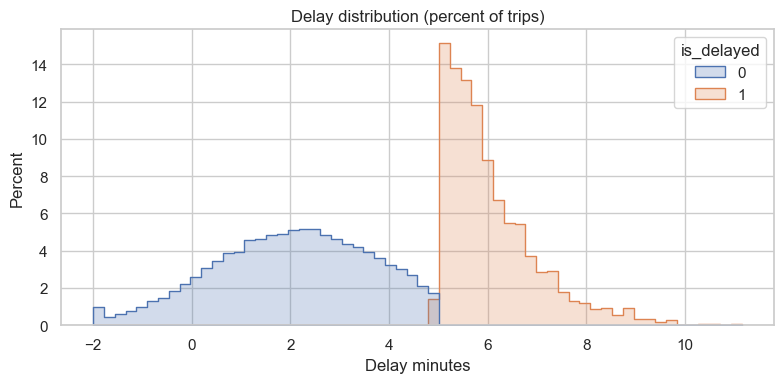

[plot] Saved outputs\gradient_descent_notebook\figures\delay_histogram.png


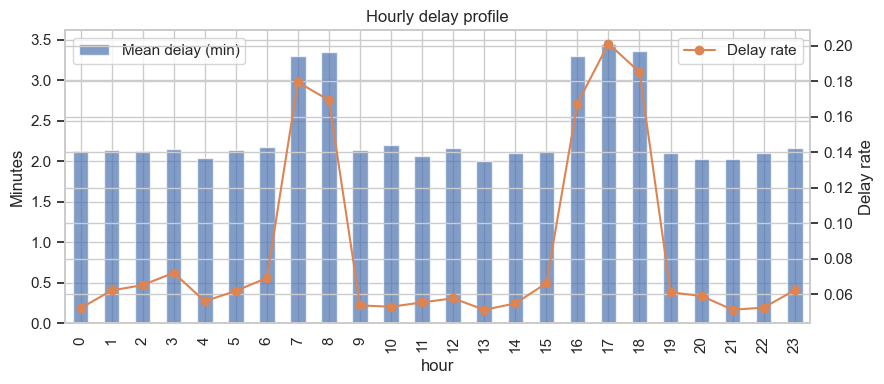

[plot] Saved outputs\gradient_descent_notebook\figures\hourly_profile.png


In [11]:
plot_delay_histogram(eda_sample)
plot_hourly_profile(eda_sample)

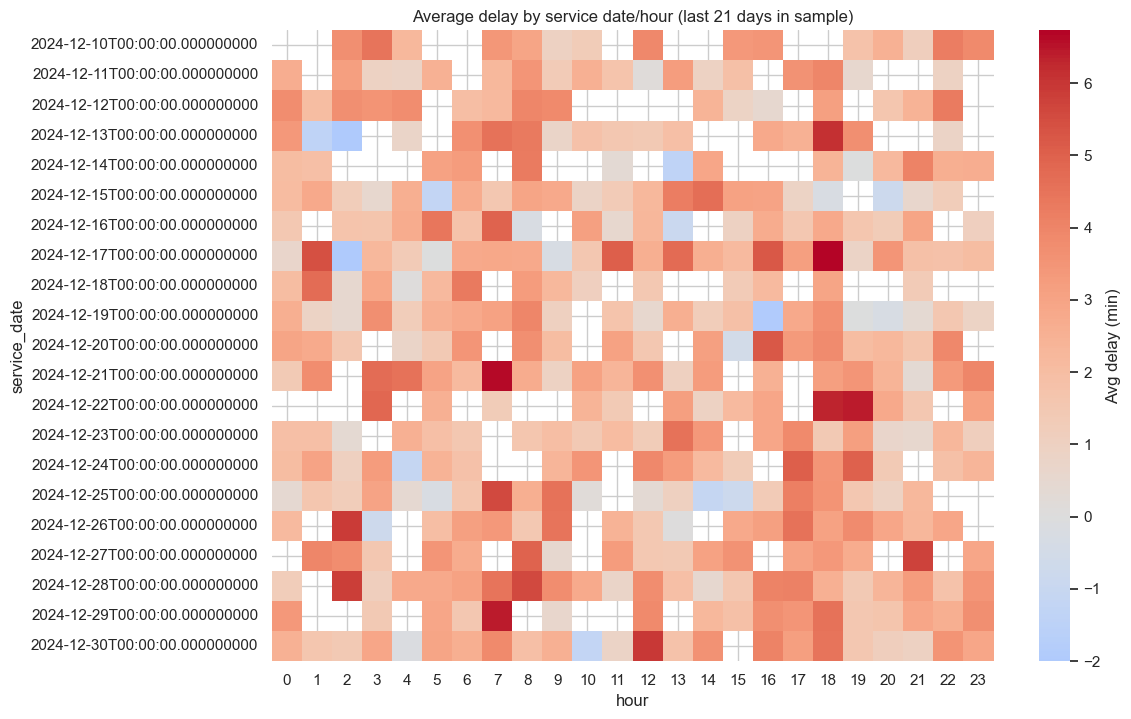

[plot] Saved outputs\gradient_descent_notebook\figures\delay_heatmap.png


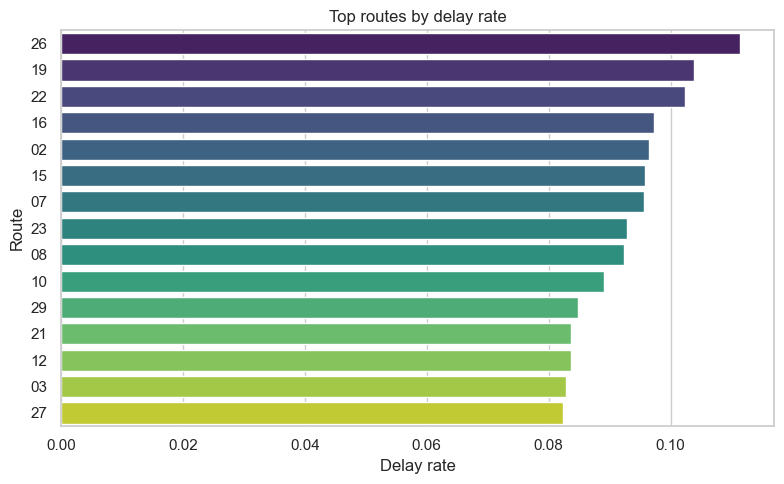

[plot] Saved outputs\gradient_descent_notebook\figures\route_delay_share.png


In [12]:
plot_service_heatmap(eda_sample)
plot_route_delay_share(eda_sample)

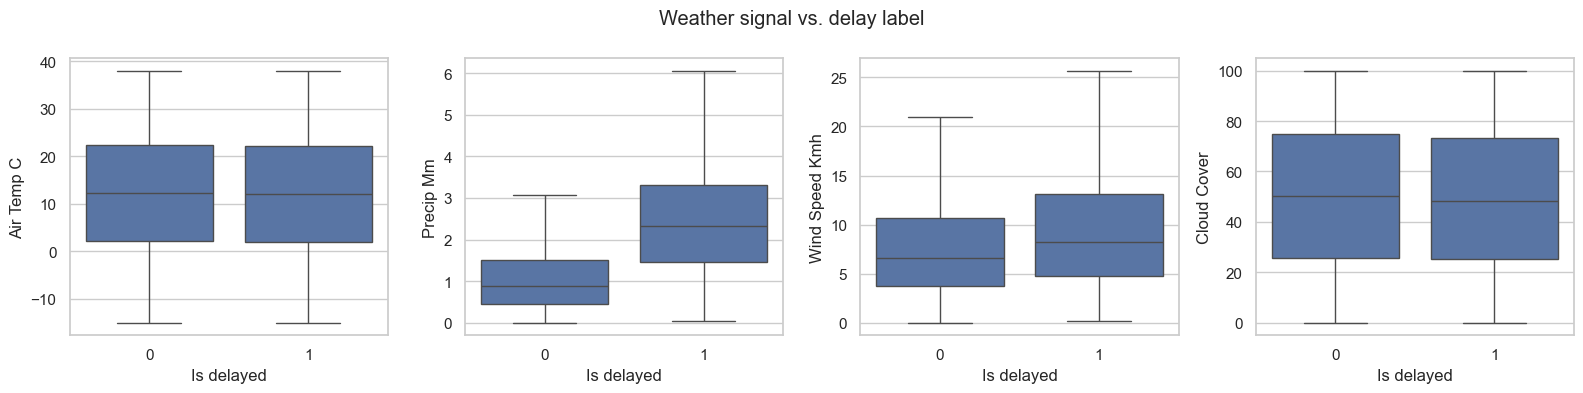

[plot] Saved outputs\gradient_descent_notebook\figures\weather_boxplots.png


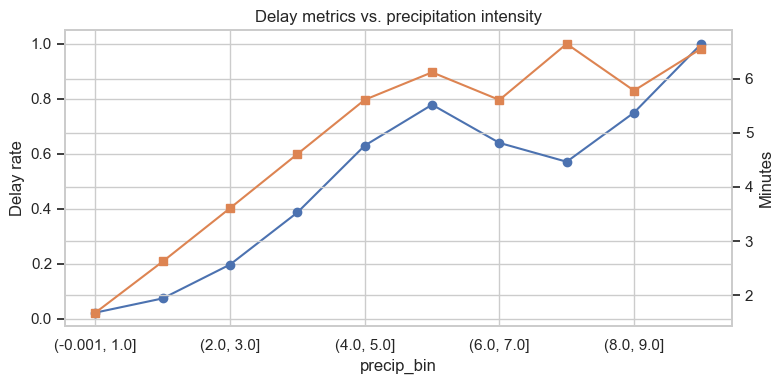

[plot] Saved outputs\gradient_descent_notebook\figures\precip_vs_delay.png


In [13]:
plot_weather_boxplots(eda_sample)
plot_precip_vs_delay(eda_sample)

## 4. Train / test split

In [14]:
split_date = CONFIG["split_date"]
train_mask = dataset["service_date"] < split_date
test_mask = dataset["service_date"] >= split_date
if not train_mask.any() or not test_mask.any():
    raise RuntimeError('Temporal split produced an empty train or test set. Adjust split_date.')

train_df = dataset.loc[train_mask].copy()
test_df = dataset.loc[test_mask].copy()
train_df, test_df = attach_route_hour_stats(train_df, test_df)

print(f"[split] Train rows: {len(train_df):,} ({train_df['is_delayed'].mean():.2%} delayed)")
print(f"[split] Test rows:  {len(test_df):,} ({test_df['is_delayed'].mean():.2%} delayed)")

[split] Train rows: 12,586 (8.58% delayed)
[split] Test rows:  12,414 (8.35% delayed)


## 5. Gradient-descent training


In [15]:
pipeline = train_model(train_df)
print("[model] Gradient-descent logistic regression fitted.")

[model] Gradient-descent logistic regression fitted.


## 6. Evaluation and diagnostics

In [16]:
metrics, eval_df = evaluate_model(pipeline, test_df, CONFIG)
print(json.dumps({k: metrics[k] for k in ["accuracy", "roc_auc", "average_precision", "brier_score", "positive_rate"]}, indent=2))
pd.DataFrame(metrics["classification_report"]).T

{
  "accuracy": 0.9130820041888191,
  "roc_auc": 0.7763446849956718,
  "average_precision": 0.278489105141005,
  "brier_score": 0.07129059380961968,
  "positive_rate": 0.08353471886579668
}


,precision,recall,f1-score,support
0,0.927516,0.981893,0.953930,11377.000000
1,0.443243,0.158149,0.233120,1037.000000
accuracy,0.913082,0.913082,0.913082,0.913082
macro avg,0.685380,0.570021,0.593525,12414.000000
weighted avg,0.887062,0.913082,0.893718,12414.000000


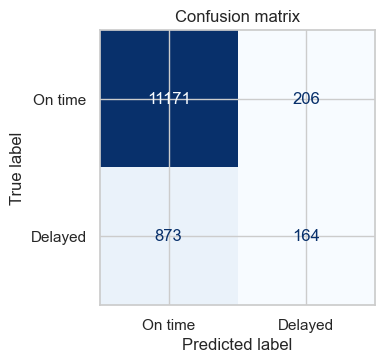

[plot] Saved outputs\gradient_descent_notebook\figures\confusion_matrix.png


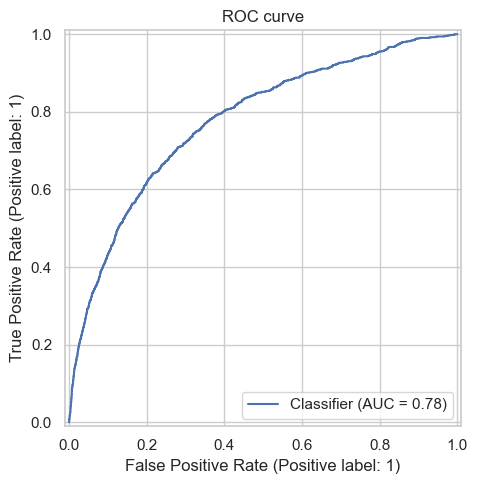

[plot] Saved outputs\gradient_descent_notebook\figures\roc_curve.png


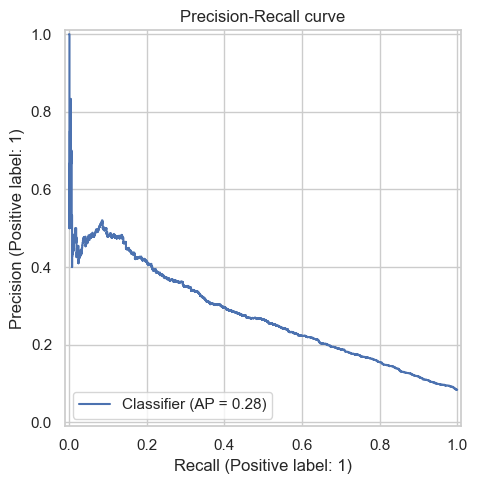

[plot] Saved outputs\gradient_descent_notebook\figures\pr_curve.png


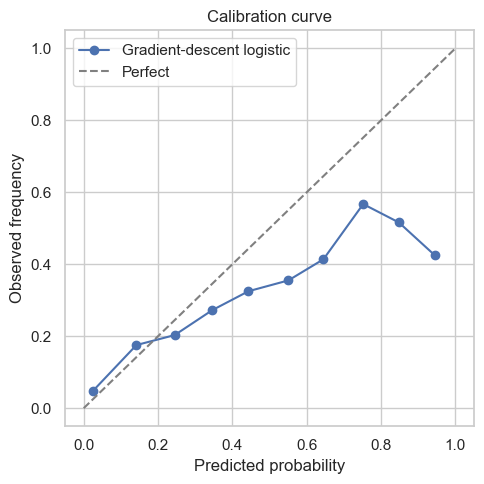

[plot] Saved outputs\gradient_descent_notebook\figures\calibration_curve.png


C:\Users\yinzhou\AppData\Local\Temp\ipykernel_2552\2364023081.py:133: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary["bucket"].astype(str), rotation=45, ha="right")


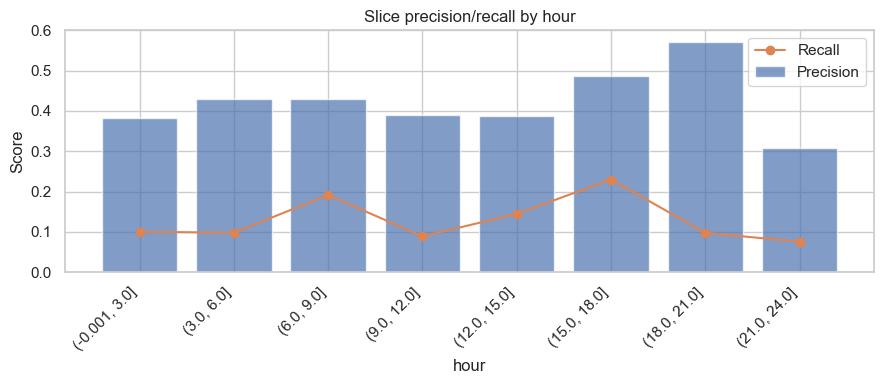

C:\Users\yinzhou\AppData\Local\Temp\ipykernel_2552\2364023081.py:133: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary["bucket"].astype(str), rotation=45, ha="right")


[plot] Saved outputs\gradient_descent_notebook\figures\slice_metrics_hour.png


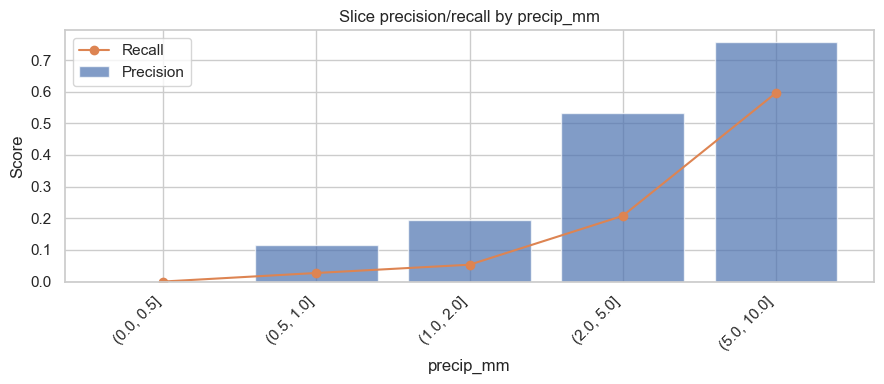

[plot] Saved outputs\gradient_descent_notebook\figures\slice_metrics_precip.png


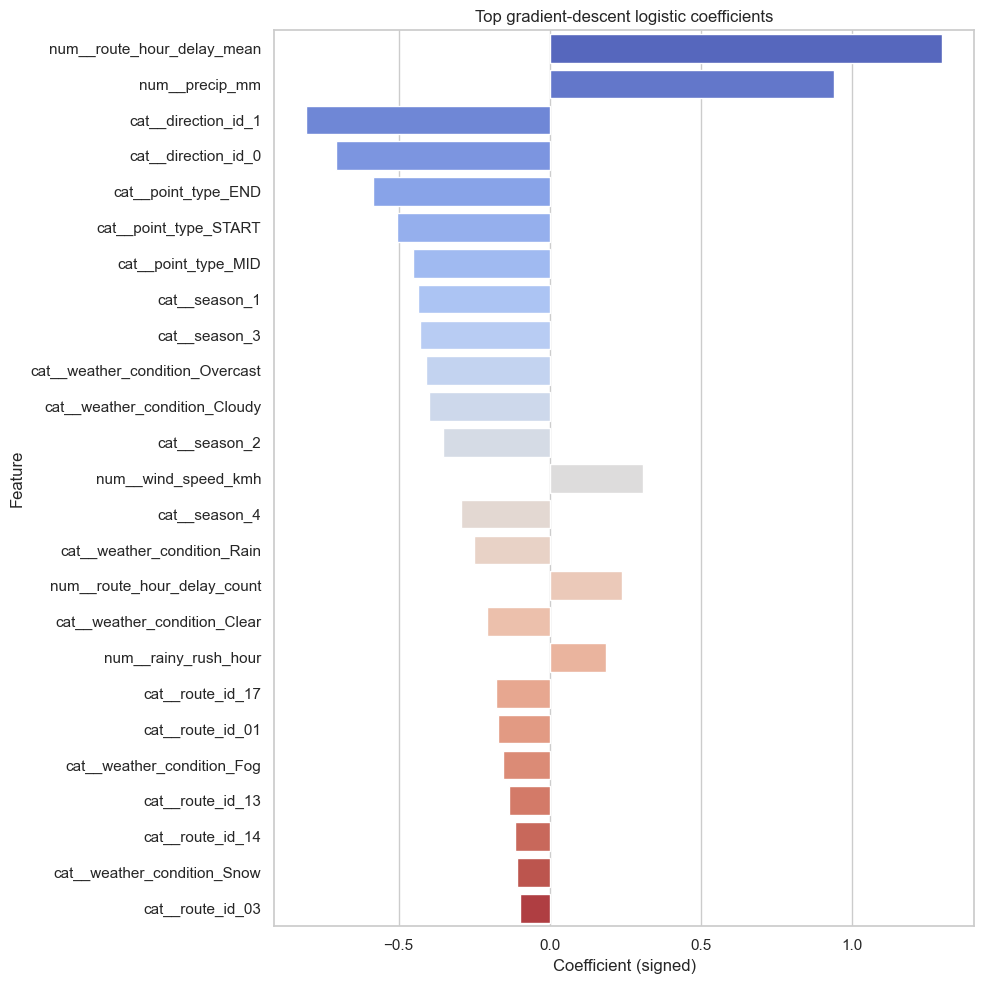

[plot] Saved outputs\gradient_descent_notebook\figures\gradient_descent_coefficients.png


In [17]:
plot_confusion(eval_df)
plot_roc(eval_df)
plot_precision_recall(eval_df)
plot_calibration(eval_df)
plot_slice_metrics(eval_df, column="hour", bins=list(range(0, 25, 3)), filename="slice_metrics_hour.png")
plot_slice_metrics(eval_df, column="precip_mm", bins=[-0.01, 0.0, 0.5, 1, 2, 5, 10], filename="slice_metrics_precip.png")
plot_feature_importance(pipeline)

## 7. Persist metrics

In [18]:
metrics_path = ARTIFACT_DIR / "gradient_descent_metrics.json"
save_metrics(metrics, metrics_path)

[metrics] Saved outputs\gradient_descent_notebook\gradient_descent_metrics.json



## Next steps

- Sweep decision thresholds or apply cost-sensitive evaluation for specific MBTA service levels.
- Extend aggregate features (e.g., rolling stop-hour averages) and re-run both gradient-descent logistic and tree models on the shared table.
- Push these routines into a reusable module so both CLI scripts and this notebook stay in sync.
